# Scrambled HCs

**Motivation** When I was modelling the HC variables, it was *very* hard to model the turn-on (I kept over predicting). 

It seems that perhaps modelling the $p_T$ ordering could be why I'm having difficulties with overpredicting the lower $m_{hh}$ region, so I want to try an experiment where I train a model with the HC variables (and the conditional masses) scrambled to see if this helps at all.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare, norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


In [18]:
hc_cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']

d0 = data()

# Add the 2b and deta_hh cuts
mh1_mask = (d0.df.m_h1 > 126-45) & (d0.df.m_h1 < 126+45)
mh2_mask = (d0.df.m_h2 > 116-45) & (d0.df.m_h2 < 116+45)
mask = mh1_mask & mh2_mask 

# This mask stays the same whether or not we scramble the HCs
mask = mask & (d0.df.ntag==2) & (d0.df.abs_deta_hh < 1.5)

SR0 = (d0.df.kinematic_region==0) & (d0.df.ntag==2) & (d0.df.abs_deta_hh < 1.5)

subDir0 = f'{(d0.subDir)}_2b_detaCut'
lr, L, H, decay = 1e-3, 5, 64, 1e-6

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


In [20]:
cis = ['log_pT_h1', 'log_pT_h2', 'eta_h2','eta_h1', 'log_dphi_hh']
d0.mlPrepare(mask,cis)

In [66]:
d1 = data()
d1.mlPrepare(mask,cis,scramble=True)

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


In [67]:
len(d1.df.index)

7496811

In [68]:
for c in d1.df.columns:
    print(c)

run_number
event_number
mc_sf
ntag
njets
kinematic_region
m_hh
pt_hh
X_wt
m_hh_cor
pT_h1
eta_h1
phi_h1
m_h1
dRjj_h1
pT_h2
eta_h2
phi_h2
m_h2
dRjj_h2
pT_2
pT_4
eta_i
dRjj_1
dRjj_2
cosThetaStar
cosTheta1
cosTheta2
Phi
Phi1
HT
MDR
MDpT
cut_deta_hh
cut_Xwt
m_hh_cor2
log_m_hh_cor2
abs_deta_hh
absCosThetaStar
log_pT_h1
log_pT_h2
dphi_hh
log_dphi_hh
Xhh_old
pT_ha
pT_hb
log_pT_ha
log_pT_hb
eta_ha
eta_hb
phi_ha
phi_hb
m_ha
m_hb
Xhh
train
val
test


**Basic EDA** 

I just want to check that my ... is working - and maybe verify that I have a comparalbe # of events in the SR.

**Compare full massplane**

In [49]:
os.sys.path.append('../eda_tools')
from plot_helper import massplane

In [84]:
kwargs = {'figsize': (10, 8),
           'bins' : (125, 125),
           'xrange': (25, 275),
           'yrange': (25, 275),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'YlGnBu',
           'title': '2b pairAGraph: only $\Delta \eta_{hh}$: scrambled HCs',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           #'filename': f'{figDir}/massplane_deta_hh_2b.pdf',
           'alpha': 0.7,
           'save': False,
           'show': True,
           'scramble': True
          }

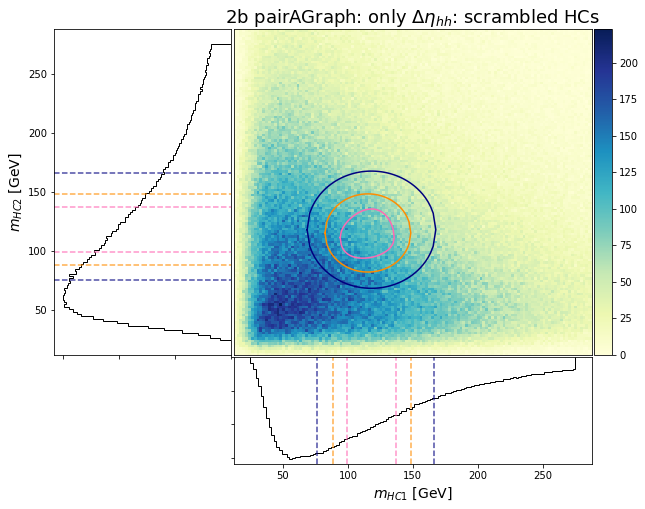

In [85]:
fig = massplane(d1.df.loc[(d1.df.ntag==2)&(d1.df.abs_deta_hh < 1.5),'m_h1'],
                d1.df.loc[(d1.df.ntag==2)&(d1.df.abs_deta_hh < 1.5),'m_h2'],
                **kwargs)

fig.show()

Sanity check the kinematic regions

In [88]:
c = (126+116)/2
CR_mask = np.sqrt((d1.df.m_h1 - c)**2 + (d1.df.m_h2-c)**2) < 45
v = (124+113)/2
VR_mask = np.sqrt((d1.df.m_h1 - v)**2 + (d1.df.m_h2-v)**2) < 30

(array([ 2580.,  7711., 12856., 17714., 22677., 27425., 32579., 37472.,
        42461., 46963.]),
 array([0.00259661, 0.16233688, 0.32207715, 0.48181742, 0.64155769,
        0.80129796, 0.96103823, 1.1207785 , 1.28051877, 1.44025904,
        1.59999931]),
 <a list of 10 Patch objects>)

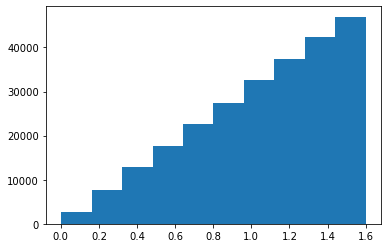

In [93]:
plt.hist(d1.df.loc[d1.df.kinematic_region ==0,'Xhh'])

In [94]:
np.max(d1.df.loc[d1.df.kinematic_region ==0,'Xhh'])

1.5999993091584488

In [98]:
Xhh = np.sqrt((10*(d1.df.m_h1 - 115)/d1.df.m_h1)**2 + (10*(d1.df.m_h2 - 115)/d1.df.m_h2)**2)


In [99]:
Xhh

0           4.198775
1           8.507274
2           3.139957
3           3.355666
4           5.551398
             ...    
7496806     4.453326
7496807     5.435301
7496808     5.384853
7496809     5.796208
7496810    29.959206
Length: 7496811, dtype: float64

In [100]:
d1.df.Xhh

0           4.198775
1           8.507274
2           3.139957
3           3.355666
4           5.551398
             ...    
7496806     4.453326
7496807     5.435301
7496808     5.384853
7496809     5.796208
7496810    29.959206
Name: Xhh, Length: 7496811, dtype: float64

k = 0


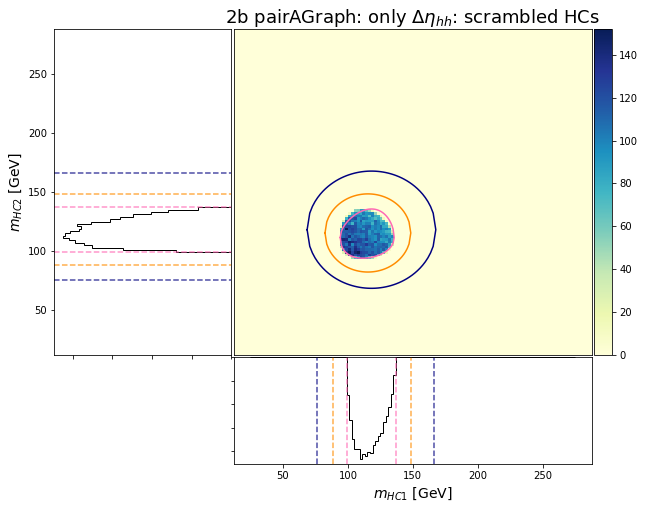

k = 1


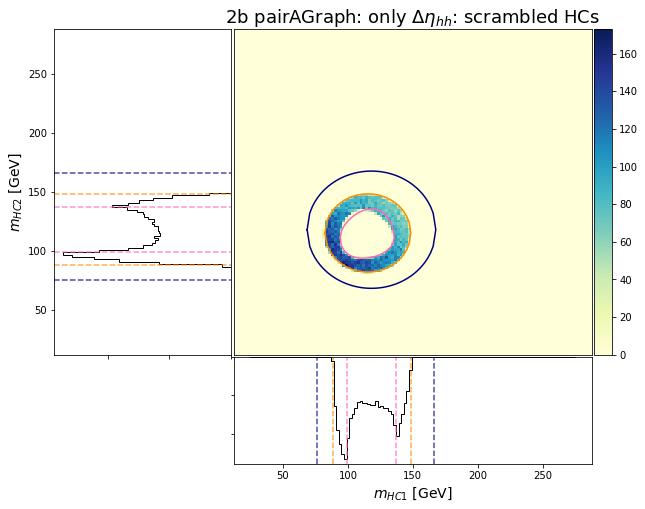

k = 2


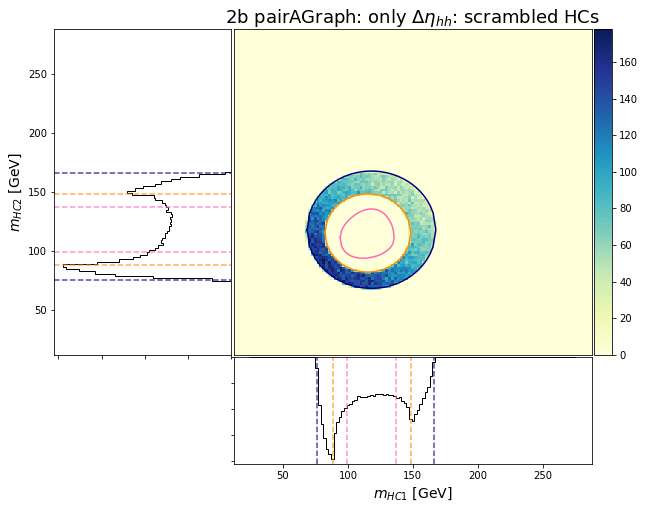

In [92]:
kwargs['save']=False
for k in range(3):

    print('k =',k)
    mk = (d1.df.ntag==2)&(d1.df.abs_deta_hh < 1.5)&(d1.df.kinematic_region==k)
    fig = massplane(d1.df.loc[mk,'m_h1'],d1.df.loc[mk,'m_h2'],**kwargs)

    fig.show()

Close enough for government work!

**$X_{hh}$**

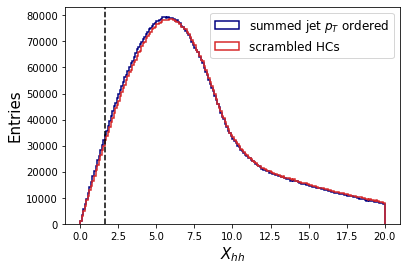

In [80]:
kwargs = {'bins':200,'range': (0,20), 'linewidth':1.5, 'histtype':'step'}

plt.hist(d1.df['Xhh_old'],color='navy',label='summed jet $p_T$ ordered',**kwargs)
plt.hist(d1.df['Xhh'],color='C3',label='scrambled HCs',**kwargs)

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('$X_{hh}$',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(fontsize=12) 

plt.show()

In [46]:
v = (124+113)/2

In [47]:
VR_mask = np.sqrt((d1.df.m_h1 - v)**2 + (d1.df.m_h2-v)**2) < 30

In [48]:
VR_mask

0          False
1          False
2          False
3          False
4          False
           ...  
7496806    False
7496807    False
7496808    False
7496809    False
7496810    False
Length: 7496811, dtype: bool

AttributeError: 'DataFrame' object has no attribute 'm_ha'

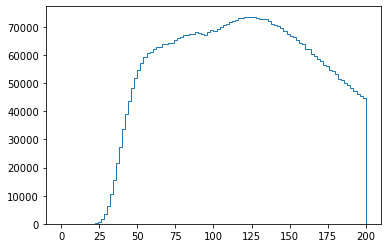

In [64]:
plt.hist(d0.df.m_h1,100,(0,200),histtype='step')
plt.hist(d1.df.m_ha,100,(0,200),histtype='step')
plt.show()

In [63]:
m

array([ True, False,  True, ...,  True, False, False])

In [62]:
# Get the random mask
m = np.random.binomial(1, 0.5, len(d0.df.index)).astype(bool)

for v in ['pT','log_pT','eta','phi']:

    # Shuffle and assign to a,b
    self.df[f'{v}_ha'] = np.where( m,d0.df[f'{v}_h1'],d0.df[f'{v}_h2'])
    self.df[f'{v}_hb'] = np.where(~m,d0.df[f'{v}_h1'],d0.df[f'{v}_h2'])

#     del self.df[f'{v}_h1']
#     del self.df[f'{v}_h2']

#     # Reassign to 1,2 so that the rest of my training code will work
#     self.df[f'{v}_h1'] = self.df[f'{v}_ha']
#     self.df[f'{v}_h2'] = self.df[f'{v}_hb']
